# Deconvolution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import load_neo, write_neo, AnalogSignal2ImageSequence, ImageSequence2AnalogSignal
import neo
import quantities as pq
import scipy.signal as signal
from scipy.signal import deconvolve, convolve, iirnotch
from scipy.stats import mode, gaussian_kde
from scipy.spatial import *
#from elephant.signal_processing import butter

## Loading .nix file

In [2]:
# load the neo block (output of the stage_01)
block = load_neo('LENS_170110_mouse2_t1.nix')

## Converting into images

Text(0.5, 0, 'time/time step')

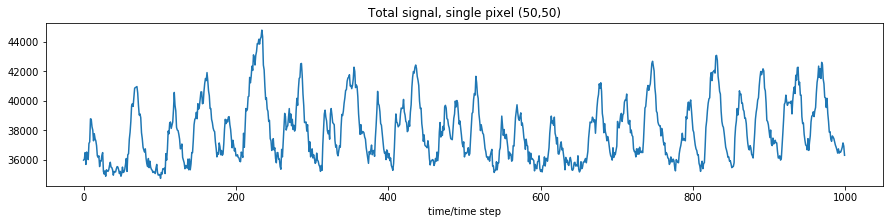

In [3]:
# trasformation in the "ImageSequence" class
blockIm = AnalogSignal2ImageSequence(block)
# converts the imagesequence class in a 3D Numpy array
imgseq = blockIm.segments[0].imagesequences[-1]
imgseq_array = imgseq.as_array()
dim_t, dim_x, dim_y = imgseq_array.shape

# plot of the total signal vs sampling time, pixel (50,50)
plt.figure(figsize=(15,3))
plt.plot(imgseq_array[:,50,50])
plt.title('Total signal, single pixel (50,50)')
plt.xlabel('time/time step')

Time and frequency axes

In [4]:
# sampling time interval (seconds)
t_step = block.segments[0].analogsignals[0].sampling_period.magnitude.tolist()
# total sampling time (seconds)
t_end = 40
# time sampling array, includes 0
time = np.arange(t_step,t_end+t_step,t_step)
# sample frequency array
freq = np.fft.rfftfreq(time.size, d=t_step)

## A closer look to the total signal

Text(0.5, 1.0, 'Phase')

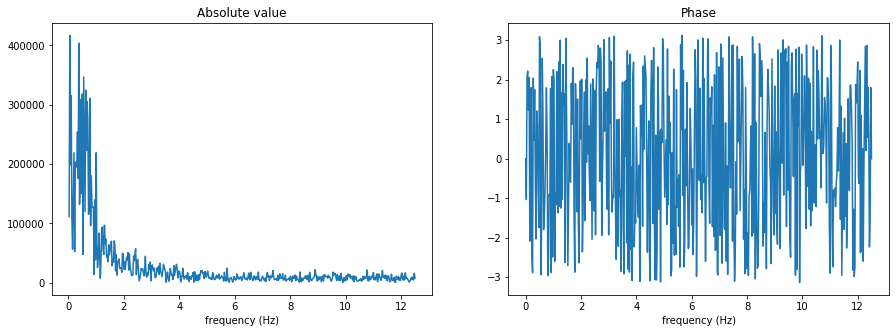

In [5]:
# Fourier transform of the (50,50) pixel
ft50 = np.fft.rfft(imgseq_array[:,50,50])
# Plotting the Fourier transform
plt.figure(1,figsize=(15,5))
plt.subplot(121)
plt.plot(freq[1:],np.abs(ft50)[1:])
plt.xlabel('frequency (Hz)')
plt.title('Absolute value')
plt.subplot(122)
plt.plot(freq, np.angle(ft50))
plt.xlabel('frequency (Hz)')
plt.title('Phase')

The signal has non-zero values at high frequencies, so the kernel function shouldn't be too close to 0

# Response function (kernel)

## Lognormal $\quad \frac{1}{t}\frac{1}{\sqrt{2\pi}\sigma} exp(-\frac{(ln (t) - \mu)^2}{2\sigma^2})$

In [6]:
def lognormal(t,mu,s):
    t_step = t[-1]/t.size
    log = 1/(t/t_step*np.sqrt(2*np.pi)*s)*np.exp(-(np.log(t/t_step)-mu)**2/(2*s**2))
    return log / (np.sum(log)*t_step)

In [7]:
# defining the guessed lognormal kernel - max in ~157.6 ms (i=394)
mean = 2.2 #2.2
sigma = 0.91 #0.91
# lognormal function array
log = lognormal(time,mean,sigma)
# calculating the Fourier transform
log_ft = np.fft.rfft(log)

## Combination of exponentials $\quad (1-e^{-t/\tau_{rise}})(e^{-t/\tau_{decay}})$

In [8]:
def combexp(t,tr,td):
    t_step = t[-1]/t.size
    func = (1-np.exp(-t/tr))*(np.exp(-t/td))
    return func / (np.sum(func)*t_step)

In [9]:
trise_exp = 0.14 #0.045 #0.14 log
tdecay_exp = 0.31 #0.142 #0.31 log
test1 = combexp(time,trise_exp,tdecay_exp)
# calculating the Fourier transform
test1_ft = np.fft.rfft(test1)

## $\alpha$- function $\quad(\frac{t}{\tau})^n e^{-t/\tau} $

In [10]:
def alpha(t,tau,n):
    t_step = t[-1]/t.size
    func = (t/tau)**n * np.exp(-t/tau)
    return func / (np.sum(func)*t_step)

In [11]:
n = 1 #0.8 log
tau = 0.2 #0.215 log 0.289 last
test2 = alpha(time,tau,n)
# calculating the Fourier transform
test2_ft = np.fft.rfft(test2)

## FT Normalization

In [12]:
freq_step = 0.025
integ_ft = np.sum(log_ft)*freq_step
integ1_ft = np.sum(test1_ft)*freq_step
integ2_ft = np.sum(test2_ft)*freq_step
log_ft_norm = log_ft / integ_ft
test1_ft_norm = test1_ft / integ1_ft
test2_ft_norm = test2_ft / integ2_ft

## Comparisons

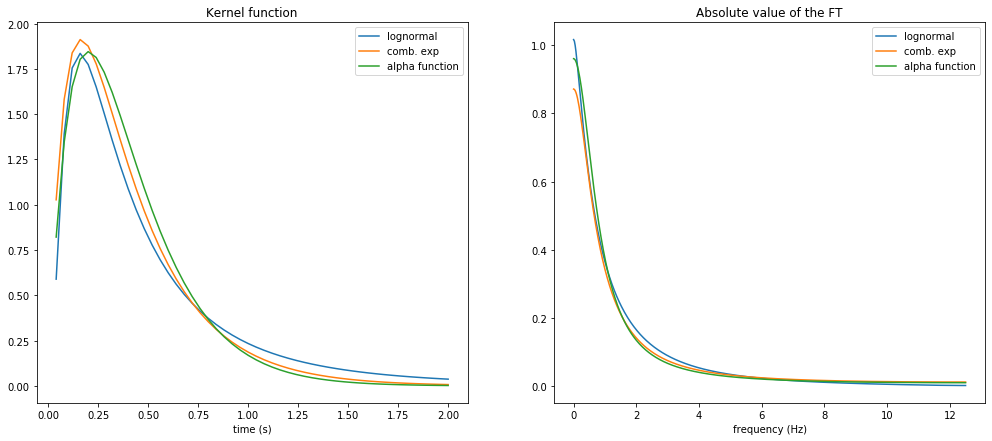

In [13]:
plt.figure(1,figsize=(17,7))
plt.subplot(121)
#plot of the kernel function
plt.plot(time[:50],log[:50], label='lognormal')
plt.plot(time[:50],test1[:50], label='comb. exp')
plt.plot(time[:50],test2[:50], label='alpha function')
plt.xlabel('time (s)')
plt.title('Kernel function')
plt.legend()
plt.subplot(122)
# plot of the absolute value of the FT
plt.plot(freq, np.abs(log_ft_norm), label='lognormal')
plt.plot(freq, np.abs(test1_ft_norm), label='comb. exp')
plt.plot(freq, np.abs(test2_ft_norm), label='alpha function')
plt.xlabel('frequency (Hz)')
plt.title('Absolute value of the FT')
plt.legend()

The FT of the lognormal kernel has a lot of values near to 0 and creates future divergence problems

## Deconvolution script(s) - single pixel

In [14]:
# LOGNORMAL - only pixel (50,50)
activity_log = deconvolve(imgseq_array[:,50,50], log[:50])

# COMB. EXP - only pixel (50,50)
activity_1 = deconvolve(imgseq_array[:,50,50],test1[:50])

# ALPHA - only pixel (50,50)
activity_2 = deconvolve(imgseq_array[:,50,50], test2[:50])

Text(0.5, 0, 'time (s)')

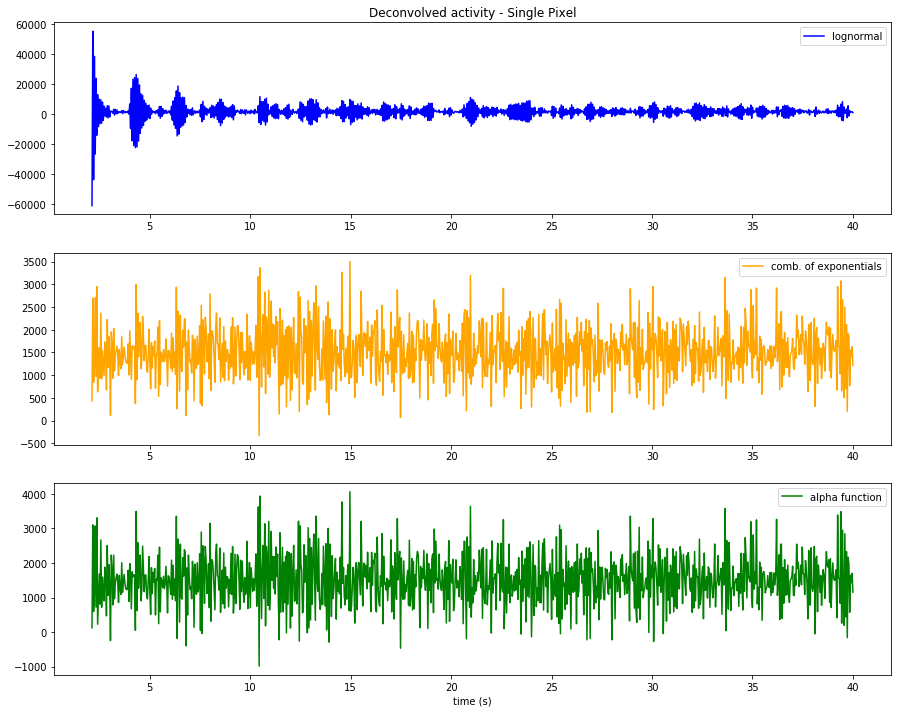

In [15]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.title('Deconvolved activity - Single Pixel')
plt.plot(time[52:], activity_log[0][3:], label='lognormal', color='blue')
plt.legend()
plt.subplot(312)
plt.plot(time[52:], activity_1[0][3:], label='comb. of exponentials', color='orange')
plt.legend()
plt.subplot(313)
plt.plot(time[52:], activity_2[0][3:], label='alpha function', color='green')
plt.legend()
plt.xlabel('time (s)')
#plt.savefig(fname='deconvolved.png', dpi=300)

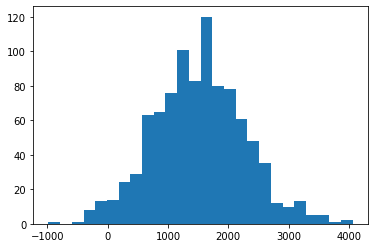

In [16]:
plt.hist(activity_2[0][3:], bins='auto')
plt.show()

# Results - Mean region

In [17]:
x_start, x_end = (50, 70) #50,70
y_start, y_end = (40, 60) #40,60
avg_region = np.zeros(dim_t)
for t in range(dim_t):
    m = 0
    for i in range(x_start, x_end):
        for j in range(y_start, y_end):
            m += imgseq_array[t][i][j]
    avg_region[t] = m / ((x_end-x_start)*(y_end-y_start))

Text(0.5, 0, 'time (s)')

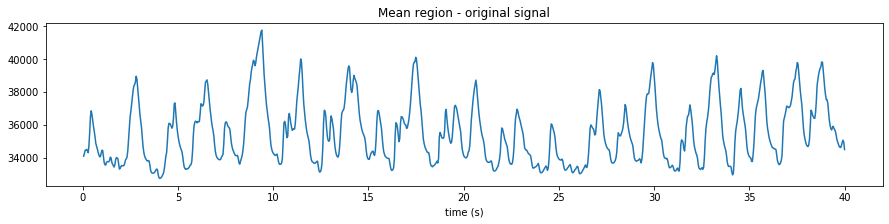

In [18]:
plt.figure(figsize=(15,3))
plt.title('Mean region - original signal')
plt.plot(time,avg_region)
plt.xlabel('time (s)')

## Initial + final ramp

In [19]:
ymin = min(avg_region) # start and end point
ylast = avg_region[-1]
y0 = avg_region[0]
ramp_length = 5 #seconds

t_first = np.arange(0,5,0.04)
t_last = np.arange(45,50,0.04)
m_first = (y0 - ymin)/ramp_length
initial_ramp = m_first*t_first + ymin
m_last = (ymin - ylast)/ramp_length
final_ramp = m_last*(t_last-t_last[0]) + ylast

time_ramp = np.append(np.append(t_first, time+5), t_last)
y_ramp = np.append(np.append(initial_ramp, avg_region), final_ramp)

Text(0.5, 0, 'time (s)')

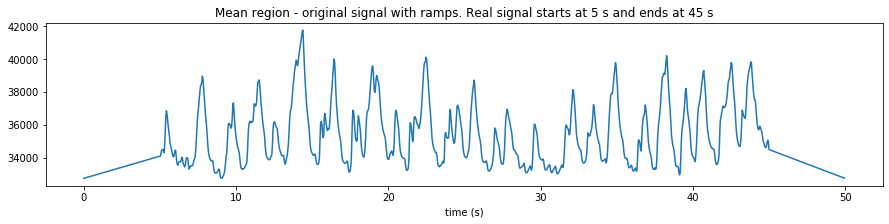

In [20]:
plt.figure(figsize=(15,3))
plt.plot(time_ramp, y_ramp)
plt.title('Mean region - original signal with ramps. Real signal starts at 5 s and ends at 45 s')
plt.xlabel('time (s)')

# Deconvolution

In [21]:
#LOGNORMAL
mean_activity_log = deconvolve(avg_region,log[:50])
#COMB. EXP.
mean_activity_1 = deconvolve(avg_region,test1[:50])
#ALPHA
mean_activity_2 = deconvolve(avg_region,test2[:50])
ramp_activity_2 = deconvolve(y_ramp, test2[:50])

## Binning and Mode

In [23]:
# kernel estimation on data
kde = gaussian_kde(ramp_activity_2[0], bw_method='silverman')
sp_def = 0.1 # fixing the resolution
delay = 125
kde_act = ramp_activity_2[0][delay:-delay]
ker_pdf = kde(np.arange(kde_act.min(), kde_act.max(), sp_def))
kde_mod = kde_act.min() + sp_def*ker_pdf.argmax()
print("mode =",kde_mod)

mode = 1380.8352682339305


In [24]:
ramp_activity_2[0].mean()

1417.472863163899

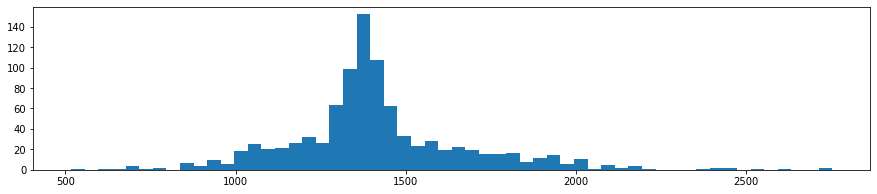

In [25]:
plt.figure(figsize=(15,3))
plt.hist(kde_act, bins='auto')
plt.show()

## Comparison

In [26]:
thre = 1300 # a occhio...

Text(0.5, 0, 'time (s)')

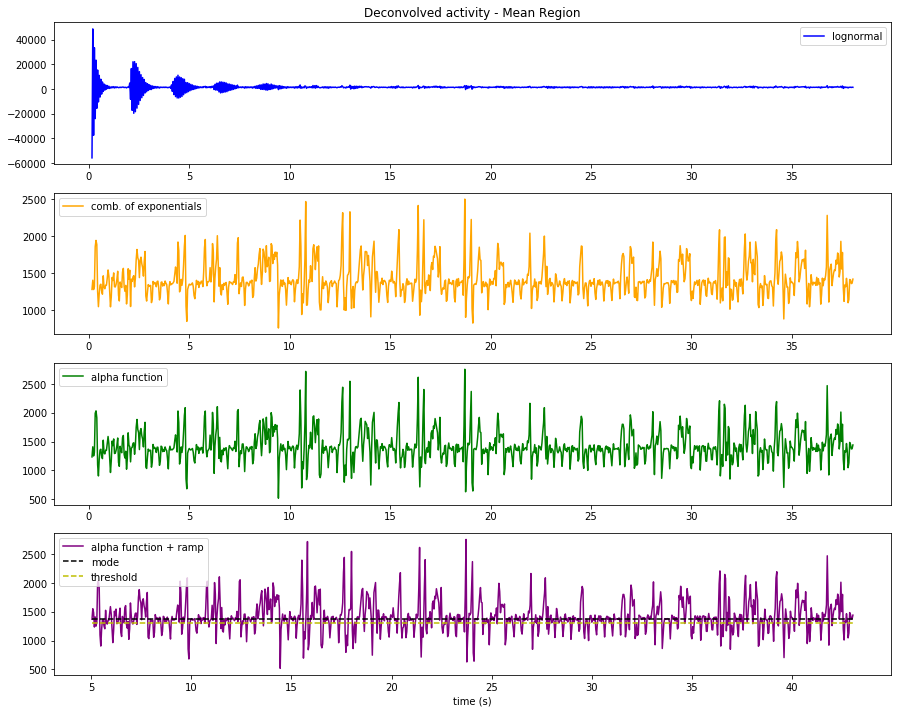

In [27]:
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.title('Deconvolved activity - Mean Region')
plt.plot(time[3:mean_activity_log[0].size], mean_activity_log[0][3:], label='lognormal', color='blue')
plt.legend()
plt.subplot(412)
plt.plot(time[3:mean_activity_1[0].size], mean_activity_1[0][3:], label='comb. of exponentials', color='orange')
plt.legend()
plt.subplot(413)
plt.plot(time[3:mean_activity_2[0].size], mean_activity_2[0][3:], label='alpha function', color='green')
plt.legend()
plt.subplot(414)
delay = 125 # 5s
plt.plot(time_ramp[delay:ramp_activity_2[0].size-delay], ramp_activity_2[0][delay:ramp_activity_2[0].size-delay], label='alpha function + ramp', color='purple')
plt.plot(time_ramp[delay:ramp_activity_2[0].size-delay], [kde_mod]*(ramp_activity_2[0].size-2*delay), '--', color = 'black', label="mode")
plt.plot(time_ramp[delay:ramp_activity_2[0].size-delay], [thre]*(ramp_activity_2[0].size-2*delay), '--', color = 'y', label="threshold")
plt.legend()
plt.xlabel('time (s)')
#plt.savefig(fname='deconvolved-mean.png', dpi=300)

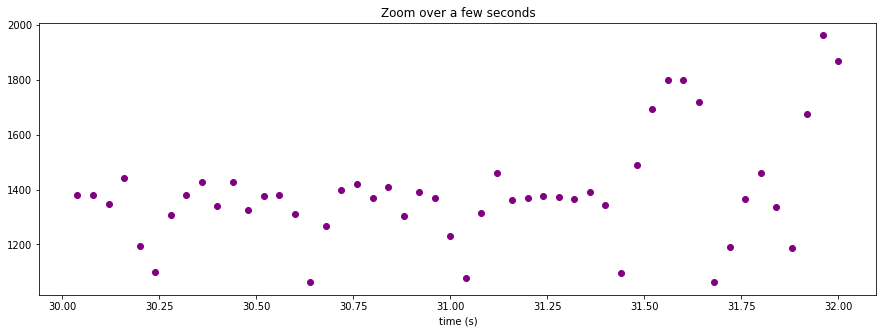

In [28]:
plt.figure(figsize=(15,5))
plt.plot(time_ramp[750:800], ramp_activity_2[0][750:800], "co", label='alpha + ramp', color='purple')
plt.title("Zoom over a few seconds")
plt.xlabel("time (s)")
plt.show()

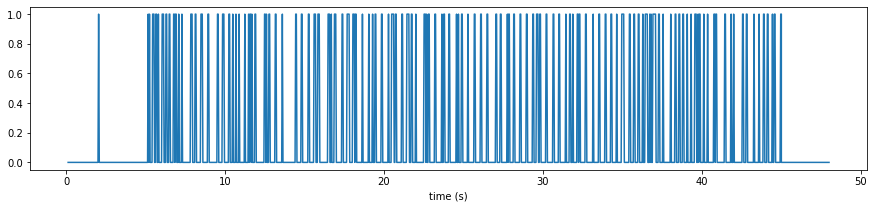

In [29]:
under = 1-np.heaviside(ramp_activity_2[0]-thre, 0)
plt.figure(figsize=(15,3))
plt.plot(time_ramp[3:ramp_activity_2[0].size], under[3:])
plt.xlabel("time (s)")
plt.show()

In [30]:
nonzero = np.heaviside(under-0.5, 0)
isi = np.diff(np.where(np.diff(nonzero) == 1))*40 #sampling rate = 40ms
#isi[0]

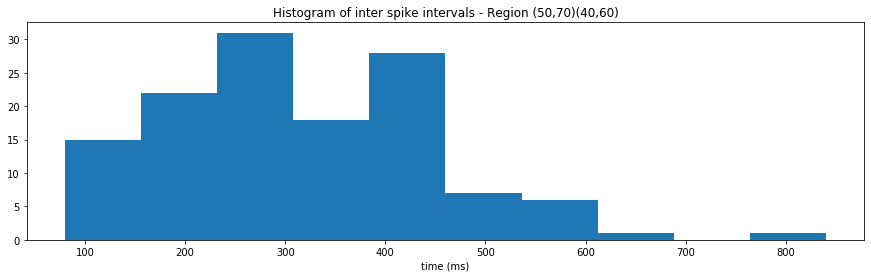

In [31]:
plt.figure(figsize=(15,4))
plt.hist(isi[0][2:], bins='auto')
plt.title("Histogram of inter spike intervals - Region (50,70)(40,60)")
plt.xlabel("time (ms)")
#plt.savefig(fname='ISI7.png')
plt.show()

## Notch filter ~5Hz

In [32]:
w0 = 5.0 #Hz
bw = 2.0
Q = w0/bw
fs = 25.0
num, den = iirnotch(w0, Q, fs)

fr, h = signal.freqz(num, den, fs=fs)

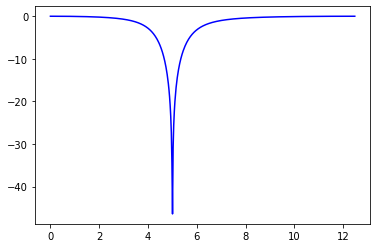

In [33]:
plt.plot(fr, 20*np.log10(abs(h)), color='blue')
plt.show()

In [34]:
notch_filtered = convolve(mean_activity_2[0], num/den)

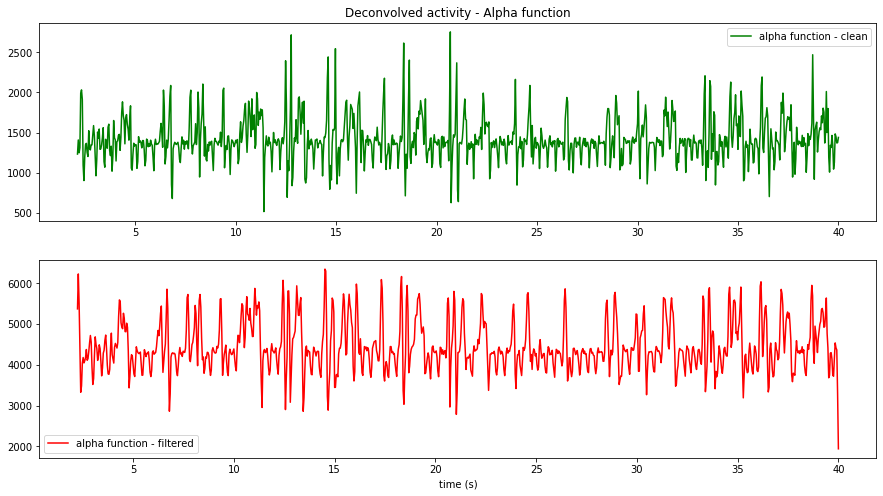

In [35]:
plt.figure(figsize=(15,8))
plt.subplot(211)
plt.title('Deconvolved activity - Alpha function')
plt.plot(time[52:], mean_activity_2[0][3:], color='green', label='alpha function - clean')
plt.legend()
plt.subplot(212)
plt.plot(time[55:], notch_filtered[8:], color='red', label='alpha function - filtered')
plt.legend()
plt.xlabel('time (s)')
plt.show()

Deconvolved activity spectrum

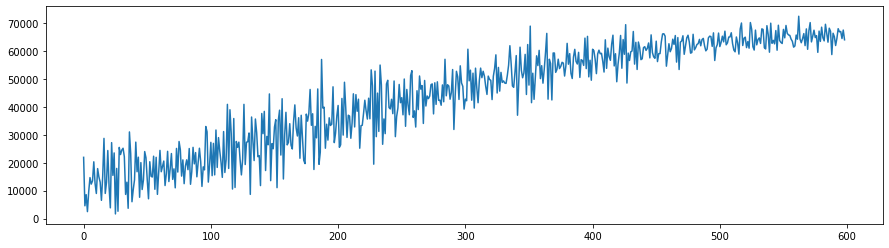

In [36]:
yfreq = np.fft.rfft(ramp_activity_2[0])

plt.figure(figsize=(15,4))
plt.plot(np.abs(yfreq[2:]))

Moving average

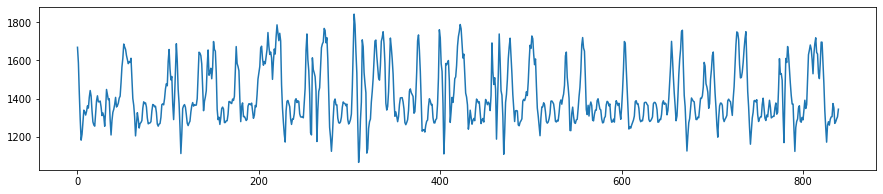

In [37]:
plt.figure(figsize=(15,3))
mov_avg = convolve([1/5,1/5,1/5,1/5,1/5],mean_activity_2[0])
plt.plot(mov_avg[10:850])

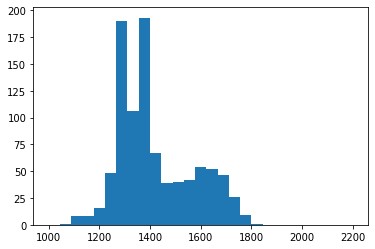

In [38]:
plt.hist(mov_avg, range=(1000,2200), bins='auto')
plt.show()

## Remainder

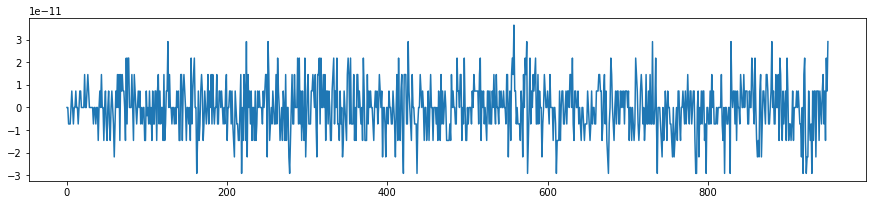

In [39]:
plt.figure(figsize=(15,3))
#plt.plot(mean_activity_1[0])
plt.plot(mean_activity_1[1][:951])

Discarded data are the last ones.

# Quality functions

## Constraint 1 : minimum distace from the guessed lognormal

In [40]:
n_start, n_end, n_step = (0, 2, 1)
tau_start, tau_end, tau_step = (0.0001, 0.2, 0.001)
alpha_matrix = np.zeros((int(n_end/n_step)+1, int(tau_end/tau_step)+1))
for i in np.arange(n_start, n_end+n_step, n_step):
    for j in np.arange(tau_start, tau_end+tau_step, tau_step):
        alpha_matrix[int(i/n_step)][int(j/tau_step)] = distance.euclidean(alpha(time, j, i), log)
        
print("Best value for n =",n_start, ": tau =",tau_start+alpha_matrix[0].argmin()*tau_step) #0.5491
print("Best value for n =",n_start+n_step, ": tau =",tau_start+alpha_matrix[1].argmin()*tau_step) #0.2051

Best value for n = 0 : tau = 0.2001
Best value for n = 1 : tau = 0.2001


In [41]:
print("Best value for n =",n_start+2*n_step, ": tau =",tau_start+alpha_matrix[2].argmin()*tau_step) #0.2051

Best value for n = 2 : tau = 0.1271


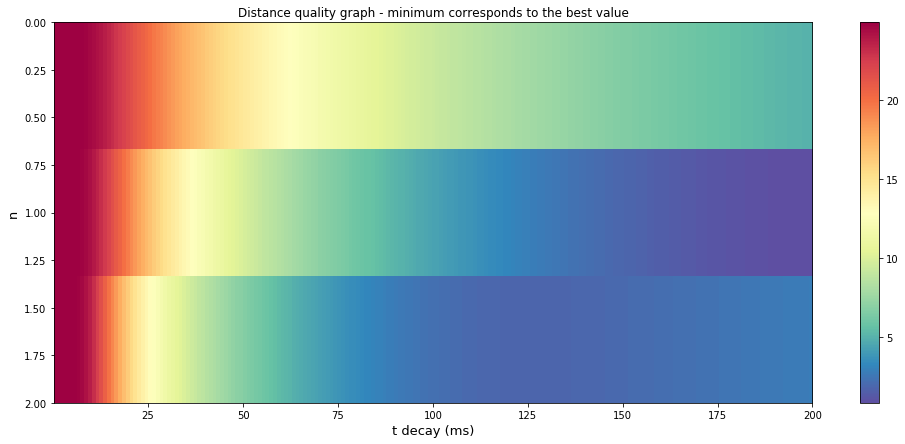

In [42]:
plt.figure(figsize = (17,7))
plt.title('Distance quality graph - minimum corresponds to the best value')
plt.imshow(alpha_matrix, extent = [tau_start*1000 , tau_end*1000, n_end , n_start], interpolation='nearest', cmap=plt.cm.Spectral_r, aspect="auto")
plt.xlabel('t decay (ms)', fontsize=13)
plt.ylabel('n', fontsize=13)

plt.colorbar()
#plt.savefig(fname='quality_dist_01.png')

## Constraint 2 : mean - mode > 0

In [43]:
sp_def = 0.1
delay = 125
n_start, n_end, n_step = (0, 2, 1)
tau_start, tau_end, tau_step = (0.001, 0.11, 0.01001)
mm_matrix = np.zeros((round((n_end-n_start)/n_step)+1, round((tau_end-tau_start)/tau_step)+1))
for i in np.arange(n_start, n_end+n_step, n_step): #blocks after n=1, j=505
    for j in np.arange(tau_start, tau_end+tau_step, tau_step):
        act = deconvolve(y_ramp, alpha(time, j, i)[:50])[0]
        act_nodiv = act[delay:-delay]
        kde = gaussian_kde(act_nodiv, bw_method='silverman')
        kde_mod = act_nodiv.min() + sp_def*kde(np.arange(act_nodiv.min(), act_nodiv.max(), sp_def)).argmax()
        med = np.mean(act)
        #print(med,kde_mod)
        if (med-kde_mod)<100:
            mm_matrix[int(round((i-n_start)/n_step))][int(round((j-tau_start)/tau_step))] = (med-kde_mod) #round() gives the .0
        else:  mm_matrix[int(round((i-n_start)/n_step))][int(round((j-tau_start)/tau_step))] = 100
            
print("Best value for n =",n_start, ": tau =",tau_start+mm_matrix[0].argmax()*tau_step)
print("Best value for n =",n_start+n_step, ": tau =",tau_start+mm_matrix[1].argmax()*tau_step)

Best value for n = 0 : tau = 0.11111
Best value for n = 1 : tau = 0.05105


In [44]:
print("Best value for n =",n_start+2*n_step, ": tau =",tau_start+mm_matrix[2].argmax()*tau_step)

Best value for n = 2 : tau = 0.031030000000000002


In [45]:
sp_def = 0.1
delay = 125
n_start, n_end, n_step = (0, 1, 1)
tau_start, tau_end, tau_step = (0.1, 0.4, 0.101)
mm_matrix = np.zeros((round((n_end-n_start)/n_step)+1, round((tau_end-tau_start)/tau_step)+1))
for i in np.arange(n_start, n_end+n_step, n_step):
    for j in np.arange(tau_start, tau_end+tau_step, tau_step):
        act = deconvolve(y_ramp, alpha(time, j, i)[:50])[0]
        act_nodiv = act[delay:-delay]
        kde = gaussian_kde(act_nodiv, bw_method='silverman')
        kde_mod = act_nodiv.min() + sp_def*kde(np.arange(act_nodiv.min(), act_nodiv.max(), sp_def)).argmax()
        med = np.mean(act)
        #print(med,kde_mod)
        if (med-kde_mod)<100:
            mm_matrix[int(round((i-n_start)/n_step))][int(round((j-tau_start)/tau_step))] = med/(med-kde_mod) #round() gives the .0
        else:  mm_matrix[int(round((i-n_start)/n_step))][int(round((j-tau_start)/tau_step))] = 1/100
            
print("Best value for n =",n_start, ": tau =",tau_start+mm_matrix[0].argmin()*tau_step)
print("Best value for n =",n_start+n_step, ": tau =",tau_start+mm_matrix[1].argmin()*tau_step)

Best value for n = 0 : tau = 0.403
Best value for n = 1 : tau = 0.403


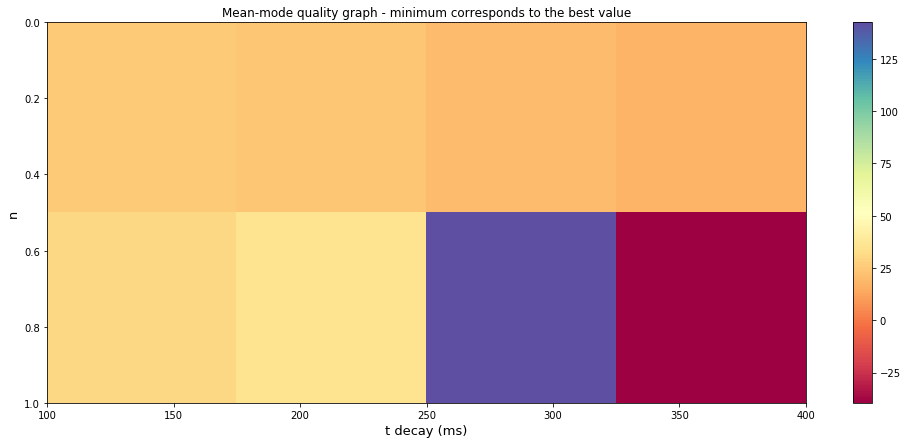

In [46]:
plt.figure(figsize = (17,7))
plt.title('Mean-mode quality graph - minimum corresponds to the best value')
plt.imshow(mm_matrix, extent = [tau_start*1000 , tau_end*1000, n_end , n_start], interpolation='nearest', cmap=plt.cm.Spectral, aspect="auto")
plt.xlabel('t decay (ms)', fontsize=13)
plt.ylabel('n', fontsize=13)

plt.colorbar()
#plt.savefig(fname='quality_mm_012_max100.png')
plt.show()

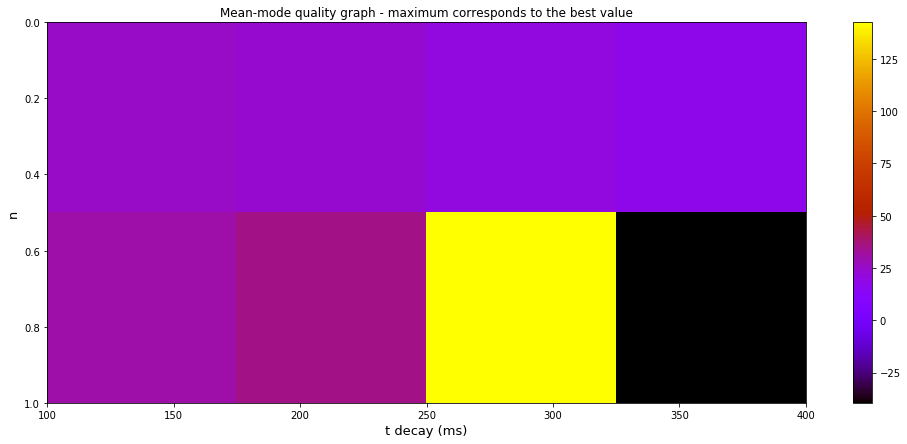

In [47]:
plt.figure(figsize = (17,7))
plt.title('Mean-mode quality graph - maximum corresponds to the best value')
plt.imshow(mm_matrix, extent = [tau_start*1000 , tau_end*1000, n_end , n_start], interpolation='nearest', cmap=plt.cm.gnuplot, aspect="auto")
plt.xlabel('t decay (ms)', fontsize=13)
plt.ylabel('n', fontsize=13)

plt.colorbar()
#plt.savefig(fname='quality_mm_012_max100.png')
plt.show()

## Constraint 3 : min(remainder)

In [48]:
n = 0.8 #log
tau = 0.215 #0.215 log # 1/10 trise (?)
n_start, n_end, n_step = (0, 1, 1)
tau_start, tau_end, tau_step = (0.0001, 0.4, 0.001)
rem_matrix = np.zeros((int((n_end-n_start)/n_step)+1, int(round((tau_end-tau_start)/tau_step)+1)))
for i in np.arange(n_start, n_end+n_step, n_step):
    for j in np.arange(tau_start, tau_end+tau_step, tau_step):
        rem = deconvolve(avg_region, alpha(time, j, i)[:50])[1][:948] # stopping the vector in order to exclude the last part of the original signal
        rem_matrix[int(round((i-n_start)/n_step))][int(round((j-tau_start)/tau_step))] = np.linalg.norm(rem)

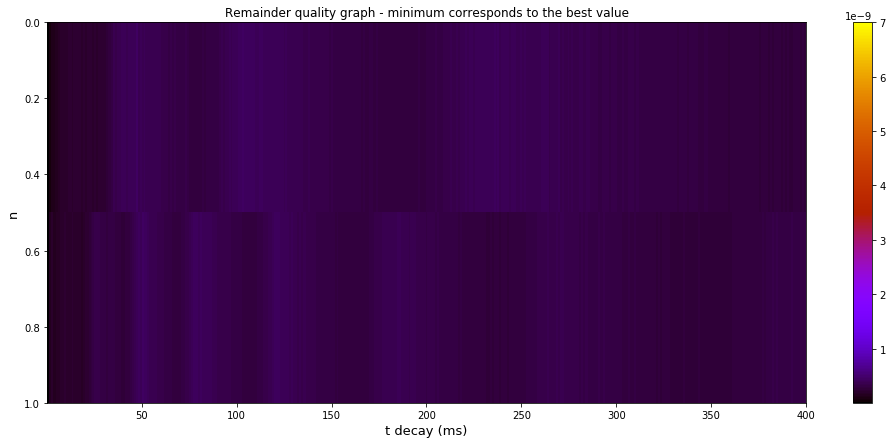

In [49]:
plt.figure(figsize = (17,7))
plt.title('Remainder quality graph - minimum corresponds to the best value')
plt.imshow(rem_matrix, extent = [tau_start*1000 , tau_end*1000, n_end , n_start], interpolation='nearest', cmap=plt.cm.gnuplot, vmax=0.000000007, aspect="auto")
plt.xlabel('t decay (ms)', fontsize=13)
plt.ylabel('n', fontsize=13)

plt.colorbar()
#plt.savefig(fname='quality_rem.png')

only n=2 produces (very) high vaues of the remainder

# Writing test

In [50]:
I = neo.ImageSequence(imgseq_array, units = block.segments[0].analogsignals[0].units, 
                      sampling_rate = block.segments[0].analogsignals[0].sampling_rate, 
                      spatial_scale = block.segments[0].imagesequences[0].spatial_scale, 
                      name = block.segments[0].analogsignals[0].name, 
                      description = block.segments[0].analogsignals[0].description)

In [51]:
S = neo.Segment()
S.imagesequences.append(I)
B = neo.Block()
B.segments.append(S)
B.name = block.name
B.description = block.description
B.annotations = block.annotations

In [52]:
out = ImageSequence2AnalogSignal(B)
out

Block with 1 segments
name: 'LENS_170110_mouse2_t1'
annotations: {'nix_name': 'neo.block.5a50d80575d24f2f8738bc84423ae2d4'}
# segments (N=1)
0: Segment with 1 analogsignals, 1 imagesequences
   # analogsignals (N=1)
   0: AnalogSignal with 10000 channels of length 1000; units dimensionless; datatype float64 
      description: 'Ca+ imaging signal. '
      annotations: {'spatial_scale': array(0.05) * mm}
      sampling rate: 25.0 Hz
      time: 0.0 s to 40.0 s

In [53]:
#write_neo('test.nix', out)